First I have to create a set of observations that I will test on. Based on a factor analysis model, this set of observations X will have have latent variables z. I can start with z to create a set of observations X. Then when I apply factor analysis to X, I should get z back.

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [177]:
N = 100  # Number of observations
M = 2  # Number of latent variables

First I create z

In [178]:
z = np.random.normal(0, 1, size=(N, M))
z[:5]

array([[-2.52188524,  0.88032744],
       [-1.04812543, -1.24906035],
       [ 1.14864631,  0.45390081],
       [ 1.23432385,  0.51606676],
       [ 3.3054963 , -0.20745204]])

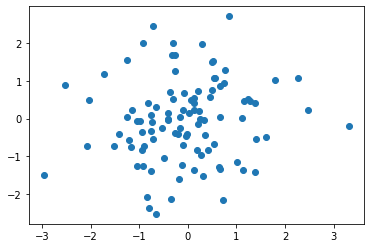

In [179]:
plt.scatter(z[:,0], z[:,1])

Now I apply a set of transformations W to get X. I want X to be a (500, 6) matrix, which means W has to be (6, 2). I will also add some mean $\mu$

In [180]:
W = np.array([[2, 3], [9, 6], [10, 9], [7, 3], [4, 2], [7, 1]])
u = np.array([8, 2, 6, 10, 3, 5])

X = (W @ z.T).T + u

X[:5]

array([[  5.59721184, -15.41500253, -11.29590546,  -5.01221437,
         -5.32688609, -11.77286925],
       [  2.15656808, -14.927491  , -15.72279748,  -1.08405909,
         -3.69062243,  -3.58593839],
       [ 11.65899506,  15.06122168,  21.57157043,  19.40222663,
          8.50238687,  13.49442501],
       [ 12.01684798,  16.2053152 ,  22.98783933,  20.18846722,
          8.96942891,  14.1563337 ],
       [ 13.98863649,  30.50475447,  37.18789466,  32.51611798,
         15.80708112,  27.93102206]])

I will use the "_L" suffix to denote learned variables. We are going to start with randomly initialized variables.

In [181]:
mu_x = np.mean(X, axis=0).reshape(-1, 1)
W_L = np.random.uniform(low=-5, high=5, size=(X.shape[1], M))
psi_L = np.diag(np.random.uniform(low=0, high=1, size=X.shape[1]))
G = inv(np.eye(M) + W_L.T @ inv(psi_L) @ W_L)


Expectation Step

In [182]:
Ez_L = np.empty(X.shape[0], dtype=object)
Ezzt_L = np.empty(X.shape[0], dtype=object)

In [183]:
for i in range(0, X.shape[0]):
    Ez_L[i] = G @ W_L.T @ inv(psi_L) @ (X[i].reshape(-1, 1) - mu_x)
    Ezzt_L[i] = G + Ez_L[i] @ Ez_L[i].T

Maximization Step

In [184]:
# Compute new W

w_sum1 = np.zeros(shape=(X.shape[1], M))

for i in range(X.shape[0]):
    w_sum1 += (X[i].reshape(-1, 1) - mu_x) @ Ez_L[i].T

W_L = w_sum1 @ inv(Ezzt_L.sum(axis=0))


In [185]:
# Compute new psi. Assuming S is the sample covariance.

psi_sum1 = np.zeros(shape=(M, X.shape[1]))

for i in range(X.shape[0]):
    psi_sum1 += Ez_L[i] @ (X[i].reshape(-1, 1) - mu_x).T
    
psi_L = np.diag(np.diag(np.cov(X.T) - (1/N) * W_L @ psi_sum1))

Now we can put it all together to try and see how close our estimation was to the real W

In [186]:
epochs = 100  # Number of iterations to run EM

mu_x = np.mean(X, axis=0).reshape(-1, 1)
W_L = np.random.uniform(low=-5, high=5, size=(X.shape[1], M))
psi_L = np.diag(np.random.uniform(low=0, high=1, size=X.shape[1]))


for _ in range(epochs):
    # Expectation Step
    Ez_L = np.empty(X.shape[0], dtype=object)
    Ezzt_L = np.empty(X.shape[0], dtype=object)
    G = inv(np.eye(M) + W_L.T @ inv(psi_L) @ W_L)
    
    for i in range(0, X.shape[0]):
        Ez_L[i] = G @ W_L.T @ inv(psi_L) @ (X[i].reshape(-1, 1) - mu_x)
        Ezzt_L[i] = G + Ez_L[i] @ Ez_L[i].T
        
        
    # Compute new W

    w_sum1 = np.zeros(shape=(X.shape[1], M))

    for i in range(X.shape[0]):
        w_sum1 += (X[i].reshape(-1, 1) - mu_x) @ Ez_L[i].T

    W_L = w_sum1 @ inv(Ezzt_L.sum(axis=0))
    
    
    # Compute new psi. Assuming S is the sample covariance.

    psi_sum1 = np.zeros(shape=(M, X.shape[1]))

    for i in range(X.shape[0]):
        psi_sum1 += Ez_L[i] @ (X[i].reshape(-1, 1) - mu_x).T
        
    psi_L = np.diag(np.diag(np.cov(X.T) - (1/N) * W_L @ psi_sum1))

In [187]:
W_L, W

(array([[-2.41955334,  3.12854163],
        [-3.60695431, 11.10699555],
        [-6.27293813, 13.26555473],
        [-1.18740097,  7.97845392],
        [-0.95588763,  4.67231431],
        [ 0.75420856,  7.18606945]]),
 array([[ 2,  3],
        [ 9,  6],
        [10,  9],
        [ 7,  3],
        [ 4,  2],
        [ 7,  1]]))

### How did I make sure the coding was done correctly?
For any problems I was having, I would look up the numpy documentation to see if the behavior I was getting was right.

### How I made sure the math I was doing was correct?

The biggest thing was to always make sure that my matrix dimensions were correct. After this, I just trusted the formulas in the book. I would also keep printing the output of steps along the way to make sure everything was correct.

### How did I plan my coding to be right?
My plan was to reverse engineer a set of latent weights. This way I had a concrete dataset that I could compare my output to, so that I could see if the model was working correctly. Other steps included using for loops instead of matrix operations. I understand matrix operations, however I do not understand the math enough to apply them to this scenario, so I stuck with loops to minimize any errors. I sacrifice run time, but it should have less problems.